In [59]:
import sys
sys.path.append('..')
sys.path.append('../..')
sys.path.append('../../..')

from selective_recruitment.plotting import make_scatterplot
from selective_recruitment.scripts.script_mapwise import calc_ttest_mean
from selective_recruitment.scripts.script_roi_differences import norm_within_category # for results after normalization
import selective_recruitment.regress as ra
import selective_recruitment.region as sroi

from statsmodels.stats.anova import AnovaRM  # perform F test
from scipy.stats import ttest_rel

from pathlib import Path
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [55]:
# setting working directory
wkdir = 'A:\data\Cerebellum\CerebellumWorkingMemory\selective_recruit'
if not Path(wkdir).exists():
    wkdir = '/srv/diedrichsen/data/Cerebellum/CerebellumWorkingMemory/selective_recruit'
if not Path(wkdir).exists():
    wkdir = '/Volumes/diedrichsen_data$/data/Cerebellum/CerebellumWorkingMemory/selective_recruit'

# selective recruitment: ROI-based
scatterplots and statistical tests on the residuals for the selected region of interest

In [56]:
# setting up names and colors
label_dict = {1: 'LfLs', 2: 'LfMs',
              3: 'LfHs', 4: 'MfLs',
              5: 'HfLs', 6:'rest'}
marker_dict = {1: '^', 2: 'X',
               3: 'X', 4: 'o',
               5: 'o', 6: 's'}
color_dict = {1: 'grey', 2: 'r',
              3: 'r', 4: 'b',
              5: 'b', 6: 'g'}

## Prepare the data for the scatterplot and the test

* Pick one parcellation: Here NettekovenSym32, a data-driven hierarchical symmetric parcellation. ROI will be selected from this parcellation.
* ss.get_summary_conn first uses a connectivity model to get predicted values for all the cerebellar voxels and then summarize the predicted values by averaging the values within the selected region of interest.


In [52]:
# get the summary df with observed and predicted activation within cerebellar parcels

## set params
dataset = "WMFS"
ses_id = 'ses-01'
parcellation = "NettekovenSym32"
cortex = "Icosahedron1002"
type = "CondHalf"
crossed = True
mname_base = f'Fusion_all_{cortex}_L2regression'
mname_ext = "_09" # if you want to use the fused model, mname_ext will be fuse_id. Use "_A8" for the non-fused model
mname_base = f'MDTB_ses-s1_{cortex}_L1regression'
mname_ext = "_A-5" # if you want to use the fused model, mname_ext will be fuse_id. Use "_A8" for the non-fused model

# get predicted and observed within region of interest
# D = ss.get_summary_conn(dataset = dataset,
#                      ses_id = ses_id,
#                      subj = None, # to do all the subjects
#                      atlas_space = "SUIT3",
#                      cerebellum_roi = parcellation,
#                      cerebellum_roi_selected = None,
#                      cortex_roi = cortex,
#                      type = type,
#                      add_rest = True,
#                      mname_base = mname_base, # Fusion_all_Icosahedron1002_L2Regression_05_avg
#                      mname_ext = mname_ext,
#                      crossed = crossed)

# apply regression to get residuals
# this second regression is implemented because direct comparison of observed and
# predicted activation is not possible due to different scaling
# D = ra.roi_regress(D, fit_intercept=True)

# save the df
# D.to_csv(wkdir + f'/fs_ROI_{parcellation}_{cortex}_{type}_{mname_base}_{mname_ext}_conn_reg.tsv', sep='\t')
D = pd.read_csv(wkdir + f'/fs_ROI_{parcellation}_{cortex}_{type}_{mname_base}_{mname_ext}_conn_reg.tsv', sep='\t')

### Select region of interest.
Here we pick one parcel by first focusing on one network, the most relevant network: here the motor network. From the sub-regions within that network, we pick the one that shows consistently high activation throughout the task

In [12]:
roi_exp = "M.." # roi_exp = "D.?3.?R|D.?3.?L" # roi_exp = "D.?3.?R"
_, _, selected_ = sroi.get_parcel_single(parcellation = parcellation,
                                               atlas_space = "SUIT3",
                                               roi_exp = roi_exp)
print(selected_)
table = pd.pivot_table(D.loc[np.isin(D.roi_name.values, selected_)], values='Y', index=['roi_name'], aggfunc=np.mean)
sorted_regions = table.sort_values(by=["Y"],ascending=False)
display(sorted_regions.T)
roi_selected = sorted_regions.T.columns[0]
print(f"selected region is {roi_selected}")


['M1L', 'M2L', 'M3L', 'M4L', 'M1R', 'M2R', 'M3R', 'M4R']


roi_name,M3R,M1R,M2R,M2L,M1L,M4R,M3L,M4L
Y,0.112481,0.101151,0.098448,0.074886,0.058411,0.051885,0.041224,0.028242


selected region is M3R


### make the scatterplot and test the residuals

                 Anova
          F Value Num DF  Den DF Pr > F
---------------------------------------
cond_name  6.7965 4.0000 60.0000 0.0001

t = 2.864, p = 0.0118


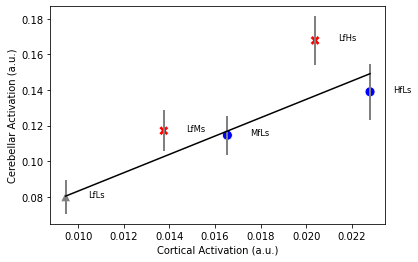

In [66]:
# get the dataframe with the selected region
mname = 'NettekovenSym32_Icosahedron1002_CondHalf_MDTB_ses-s1_Icosahedron1002_L2regression__A8'
D = pd.read_csv(wkdir + f'/fs_ROI_{mname}_conn_reg.tsv', sep='\t')
selected_roi = "M3R"
df = D.loc[(D.roi_name == selected_roi) & (D.cond_name != 'rest')]
make_scatterplot(df, split='cond_num',
                labels=label_dict,
                markers=marker_dict,
                colors=color_dict)
# plt.xlabel("predicted cerebellar activation")
#  plt.savefig(f"fs_{selected_roi}_scatter_selected_model.pdf")
print(AnovaRM(data=df, depvar='res',subject='sn', within=['cond_name'], aggregate_func=np.mean).fit())

#define samples
group1 = pd.pivot_table(df[(df['cond_name']=='HL   ') ],values='res',index='sn')
group2 = pd.pivot_table(df[(df['cond_name']=='LH   ') ],values='res',index='sn')

t,p=ttest_rel(group2,group1)
print(f't = {t[0]:.3f}, p = {p[0]:.4f}')


### Add Supplemental table here (across different connectivity models)

In [58]:
## Make table with statistical values
mname = ['NettekovenSym32_Icosahedron1002_CondHalf_Fusion_all_Icosahedron1002_L2regression__09',
        'NettekovenSym32_Icosahedron1002_CondHalf_MDTB_ses-s1_Icosahedron1002_L2regression__A8',
        'NettekovenSym32_Icosahedron1002_CondHalf_MDTB_ses-s1_Icosahedron1002_L1regression__A-5',
        'NettekovenSym32_Icosahedron1002_CondHalf_MDTB_all_Icosahedron1002_L2regression__A8',
        'NettekovenSym32_Icosahedron1002_CondHalf_MDTB_all_Icosahedron1002_L1regression__A-5']
selected_roi = "M3R"
for m in mname:
    D = pd.read_csv(wkdir + f'/fs_ROI_{m}_conn_reg.tsv', sep='\t')
    df = D.loc[(D.roi_name == selected_roi) & (D.cond_name != 'rest')]
    res = (AnovaRM(data=df[df.cond_name != 'rest'], depvar='res',subject='sn', within=['cond_name'], aggregate_func=np.mean).fit())
    print(res.summary())
    #define samples
    group1 = pd.pivot_table(df[(df['cond_name']=='HL   ') ],values='res',index='sn')
    group2 = pd.pivot_table(df[(df['cond_name']=='LH   ') ],values='res',index='sn')

    t,p=ttest_rel(group2,group1)
    print(f"t = {t[0]:.3f}, p = {p[0]:.4f}")

                 Anova
          F Value Num DF  Den DF Pr > F
---------------------------------------
cond_name  5.0478 4.0000 60.0000 0.0014

t = [2.13990841], p = [0.0492064]
                 Anova
          F Value Num DF  Den DF Pr > F
---------------------------------------
cond_name  6.7965 4.0000 60.0000 0.0001

t = [2.86390877], p = [0.01182881]
                 Anova
          F Value Num DF  Den DF Pr > F
---------------------------------------
cond_name  4.9802 4.0000 60.0000 0.0016

t = [2.37268954], p = [0.03145777]
                 Anova
          F Value Num DF  Den DF Pr > F
---------------------------------------
cond_name  3.8944 4.0000 60.0000 0.0071

t = [1.85445046], p = [0.08343988]
                 Anova
          F Value Num DF  Den DF Pr > F
---------------------------------------
cond_name  3.2061 4.0000 60.0000 0.0188

t = [1.76039674], p = [0.0987095]
